In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import torch
import torchvision.transforms as T
from shutil import rmtree
from sklearn.model_selection import train_test_split
from tqdm.autonotebook import tqdm, trange
from torch.nn.functional import softmax
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.datasets import ImageFolder

from predictors.alexnet import Alexnet
from predictors.half_alexnet import HalfAlexnet

from datasets import CIFAR10, ProxyDataset

%matplotlib inline

In [3]:
LR = 0.001
EPOCHS = 200
BATCH_SIZE = 32
CONFIDENCE_TH = 0.8

DATASET_PATH = '.'
TEMP_BEST_MODEL = 'cosine_weighted_experiments'

# Set random seed for replicating testing results
RANDOM_SEED = 0
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# Teacher
teacher_model = Alexnet(name=None, n_outputs=10)

ckpt_path = 'checkpoints/teacher_alexnet_for_cifar10_state_dict'
teacher_model.load_state_dict(torch.load(ckpt_path, map_location=device))
teacher_model.eval()
teacher_model = teacher_model.to(device)

In [5]:
# Define dataset
label_mapper = {
    'airplane': 0,
    'automobile': 1,
    'bird': 2,
    'cat': 3,
    'deer': 4,
    'dog': 5,
    'frog': 6,
    'horse': 7,
    'ship': 8,
    'truck': 9
}
label_mapper_inv = {v:k for k,v in label_mapper.items()}

# Get images paths and labels
images = []
labels = []

folders_path = os.path.join(DATASET_PATH,'images_generated')
for folder in os.listdir(folders_path):
    if 'imagenet' in folder:
      continue
    class_path = os.path.join(folders_path,folder)
    images_names = os.listdir(class_path)
    
    for image_name in images_names:
        images.append(os.path.join(class_path,image_name))
        labels.append(label_mapper[folder])

In [6]:
proxy_transforms = T.Compose([
    T.Resize((32,32)),
    T.Normalize((0.5,), (0.5,))
])

proxy_dataset = ProxyDataset(images, labels, proxy_transforms, True)
proxy_dataloader  = DataLoader(proxy_dataset,  batch_size=BATCH_SIZE)

# Obtain teacher predictions
filtered_images = []
filtered_labels = []
filtered_soft_labels = []

with torch.no_grad():
    for img,label,path,_ in tqdm(proxy_dataloader):
        img = img.to(device=device)
        label = label.to(device=device)

        logits = teacher_model(img)
        pred = softmax(logits, dim=1)
        
        confidence,y_hat = torch.max(pred, dim=1)

        filtered_images.extend(list(path))
        filtered_labels.extend(y_hat.tolist())
        filtered_soft_labels.extend(pred)
        
# Display results of filtering
print(f'A total of {len(filtered_images)} remained out of {len(proxy_dataset)}')
print()
counter_per_class = {v:0 for k,v in label_mapper.items()}
for label in filtered_labels:
    counter_per_class[label] += 1
for clasa in counter_per_class:
    print(f'Class {clasa}({label_mapper_inv[clasa]}) has {counter_per_class[clasa]} entries')

  0%|          | 0/1600 [00:00<?, ?it/s]

A total of 51200 remained out of 51200

Class 0(airplane) has 6384 entries
Class 1(automobile) has 5145 entries
Class 2(bird) has 4795 entries
Class 3(cat) has 5331 entries
Class 4(deer) has 5571 entries
Class 5(dog) has 4286 entries
Class 6(frog) has 4553 entries
Class 7(horse) has 5025 entries
Class 8(ship) has 5178 entries
Class 9(truck) has 4932 entries


In [7]:
# Define the student model
student_model = HalfAlexnet(name=None, n_outputs=10)

path_to_save = 'pretrained_student.pt'
if torch.cuda.is_available():
    student_model.load_state_dict(torch.load(path_to_save))
else:
    student_model.load_state_dict(torch.load(path_to_save, map_location ='cpu'))
student_model.to(device)

# Define optimizer
optimizer = torch.optim.Adam(student_model.parameters(), lr=LR)

# Define loss function
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

In [8]:
try:
  # raise
  # Do a stratified split of the data
  NO_IMGS_TO_USE = 60
  
  filtered_images_subset, filtered_images_unused, filtered_labels_subset, filtered_labels_unused, filtered_soft_labels_subset, filtered_soft_labels_unused = \
      train_test_split(filtered_images, filtered_labels, filtered_soft_labels, train_size=NO_IMGS_TO_USE, stratify=filtered_labels, random_state=RANDOM_SEED)  

  train_images, validation_images, train_labels, validation_labels, train_soft_labels, validation_soft_labels = \
      train_test_split(filtered_images_subset, filtered_labels_subset, filtered_soft_labels_subset, train_size=0.8, stratify=filtered_labels_subset, random_state=RANDOM_SEED)
  valid_images, test_images, valid_labels, test_labels, valid_soft_labels, test_soft_labels = \
      train_test_split(validation_images, validation_labels, validation_soft_labels, test_size=0.5, stratify=validation_labels, random_state=RANDOM_SEED)
except:
  # For small datasets 
  print('Small dataset')
  NO_IMGS_TO_USE = 60
  NO_TRAIN_IMGS = 40

  """ DEV - train_test_split fails, need to manually introduce 1 sample
  for i in range(len(filtered_labels)-1,-1,-1):
    if filtered_labels[i] == 5:
      img_dev = filtered_images[i]
      soft_label_dev = filtered_soft_labels[i]
      break
  """

  filtered_images_subset, filtered_images_unused, filtered_labels_subset, filtered_labels_unused, filtered_soft_labels_subset, filtered_soft_labels_unused = \
    train_test_split(filtered_images, filtered_labels, filtered_soft_labels, train_size=NO_IMGS_TO_USE, stratify=filtered_labels, random_state=RANDOM_SEED)  
  train_images, validation_images, train_labels, validation_labels, train_soft_labels, validation_soft_labels = \
    train_test_split(filtered_images_subset, filtered_labels_subset, filtered_soft_labels_subset, train_size=NO_TRAIN_IMGS, stratify=filtered_labels_subset, random_state=RANDOM_SEED)
  
  """ DEV - interchange an image
  for i in range(len(validation_images)):
    if validation_labels[i] == 0:
      validation_images[i] = img_dev
      validation_labels[i] = 5
      validation_soft_labels[i] = soft_label_dev
      break
  """

  valid_images, test_images, valid_labels, test_labels, valid_soft_labels, test_soft_labels = \
      train_test_split(validation_images, validation_labels, validation_soft_labels, test_size=0.5, stratify=validation_labels)

Small dataset


In [9]:
# Define the transformations
train_transforms = T.Compose([
    T.Resize((32,32)),
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(p=0.5),
    T.Normalize((0.5,), (0.5,))
])
valid_transforms = T.Compose([
    T.Resize((32,32)),
    T.Normalize((0.5,), (0.5,))
])

# Define the proxy datasets
proxy_train_dataset = ProxyDataset(train_images, train_labels, train_transforms, False, train_soft_labels)
proxy_valid_dataset = ProxyDataset(valid_images, valid_labels, valid_transforms, False, valid_soft_labels)
proxy_test_dataset  = ProxyDataset(test_images,  test_labels,  valid_transforms, False, test_soft_labels)

# Define the proxy dataloaders
train_dataloader = DataLoader(proxy_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(proxy_valid_dataset, batch_size=BATCH_SIZE)
test_dataloader  = DataLoader(proxy_test_dataset,  batch_size=BATCH_SIZE)

# Define true dataset
true_dataset = CIFAR10(input_size = 32)

validate_on_trueds = True
if validate_on_trueds:
    true_valid_ds = true_dataset.test_dataloader()

Files already downloaded and verified
Files already downloaded and verified


In [10]:
# Class for early stopping
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.min_valid_loss = np.inf
        self.early_stop = False

    def __call__(self, validation_loss):
        if validation_loss < self.min_valid_loss:
          self.min_valid_loss = validation_loss
          self.counter = 0
        elif validation_loss > self.min_valid_loss + self.min_delta:
          self.counter +=1
          
          if self.counter >= self.tolerance:  
              self.early_stop = True

In [11]:
early_stopping = EarlyStopping(tolerance=5, min_delta=0.05)
# early_stopping = EarlyStopping(tolerance=5, min_delta=0.001)

best_accuracy = 0.0
# Training the student
for epoch in range(EPOCHS):
    # Define progress bar
    loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    
    # Training loop
    student_model.train()
    training_loss_epoch = []
    for batch_idx, (x,y,soft_y) in loop:
        optimizer.zero_grad()
        
        x = x.to(device=device)
        y = y.to(device=device)
        soft_y = soft_y.to(device=device)
        
        # Forward pass
        logits = student_model(x)
        # Backward pass
        loss = criterion(input=logits, target=soft_y)
        training_loss_epoch.append(loss.item())
        # Prob trb inlocuit criterionul, sa adaugi soft-labels
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        # Update progress bar
        loop.set_description(f'Epoch {epoch+1}/{EPOCHS}')
        loop.set_postfix(training_loss=loss.item())
    
    # Validation loop on proxy validation dataset
    student_model.eval()
    validation_loss_epoch = []  
    acc = 0
    with torch.no_grad():
        for x,y,_ in valid_dataloader:
            x = x.to(device=device)
            y = y.to(device=device)
        
            logits = student_model(x)
            pred = softmax(logits, dim=1)
            
            confidence,y_hat = torch.max(pred, dim=1)
            
            loss = criterion(input=logits, target=y)
            validation_loss_epoch.append(loss.item())
            
            acc += torch.sum(y_hat==y).item()
        
    loop.write(f'validation_loss on proxy = {sum(validation_loss_epoch)/len(validation_loss_epoch):.4f}')
    loop.write(f'validation_accuracy on proxy = {100*acc/len(proxy_valid_dataset):.2f}%')

    # Save best model
    valid_proxy_acc = acc/len(proxy_valid_dataset)
    if valid_proxy_acc > best_accuracy:
        best_accuracy = valid_proxy_acc
        torch.save(student_model.state_dict(), f'temp_models/{TEMP_BEST_MODEL}.pt')
        print(f'Saved at epoch {epoch}')

    if validate_on_trueds:
        # Validation loop on proxy validation dataset
        student_model.eval()
        with torch.no_grad():
            val_loss = []
            acc = 0
            for x,y in true_valid_ds:
                x = x.to(device=device)
                y = y.to(device=device)
            
                logits = student_model(x)
                pred = softmax(logits, dim=1)
                
                confidence,y_hat = torch.max(pred, dim=1)
                
                loss = criterion(input=logits, target=y)
                val_loss.append(loss.item())
                
                acc += torch.sum(y_hat==y).item()
            
        loop.write(f'validation_loss on true ds = {sum(val_loss)/len(val_loss):.4f}')
        loop.write(f'validation_accuracy on true ds = {100*acc/len(true_dataset.test_dataset):.2f}%')

        
    early_stopping(sum(validation_loss_epoch)/len(validation_loss_epoch))
    if early_stopping.early_stop:
      print(f"We are at epoch {epoch}")
      break

student_model.load_state_dict(torch.load(f'temp_models/{TEMP_BEST_MODEL}.pt'))

  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 2.1485
validation_accuracy on proxy = 30.00%
Saved at epoch 0
validation_loss on true ds = 2.2468
validation_accuracy on true ds = 14.42%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 2.1105
validation_accuracy on proxy = 30.00%
validation_loss on true ds = 2.2264
validation_accuracy on true ds = 16.21%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 2.0800
validation_accuracy on proxy = 40.00%
Saved at epoch 2
validation_loss on true ds = 2.2114
validation_accuracy on true ds = 17.34%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 2.0617
validation_accuracy on proxy = 50.00%
Saved at epoch 3
validation_loss on true ds = 2.1996
validation_accuracy on true ds = 18.28%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 2.0325
validation_accuracy on proxy = 50.00%
validation_loss on true ds = 2.1852
validation_accuracy on true ds = 19.27%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 2.0046
validation_accuracy on proxy = 50.00%
validation_loss on true ds = 2.1676
validation_accuracy on true ds = 20.49%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.9845
validation_accuracy on proxy = 50.00%
validation_loss on true ds = 2.1541
validation_accuracy on true ds = 21.68%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.9766
validation_accuracy on proxy = 50.00%
validation_loss on true ds = 2.1476
validation_accuracy on true ds = 22.00%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.9672
validation_accuracy on proxy = 50.00%
validation_loss on true ds = 2.1387
validation_accuracy on true ds = 22.74%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.9353
validation_accuracy on proxy = 50.00%
validation_loss on true ds = 2.1281
validation_accuracy on true ds = 23.57%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.9145
validation_accuracy on proxy = 40.00%
validation_loss on true ds = 2.1225
validation_accuracy on true ds = 23.88%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.8883
validation_accuracy on proxy = 40.00%
validation_loss on true ds = 2.1110
validation_accuracy on true ds = 25.23%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.8569
validation_accuracy on proxy = 40.00%
validation_loss on true ds = 2.1006
validation_accuracy on true ds = 26.23%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.8221
validation_accuracy on proxy = 50.00%
validation_loss on true ds = 2.0938
validation_accuracy on true ds = 25.55%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.7965
validation_accuracy on proxy = 50.00%
validation_loss on true ds = 2.0810
validation_accuracy on true ds = 26.40%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.7764
validation_accuracy on proxy = 50.00%
validation_loss on true ds = 2.0730
validation_accuracy on true ds = 26.70%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.7601
validation_accuracy on proxy = 50.00%
validation_loss on true ds = 2.0643
validation_accuracy on true ds = 27.57%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.7358
validation_accuracy on proxy = 50.00%
validation_loss on true ds = 2.0573
validation_accuracy on true ds = 27.39%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.7075
validation_accuracy on proxy = 50.00%
validation_loss on true ds = 2.0524
validation_accuracy on true ds = 27.89%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.6823
validation_accuracy on proxy = 50.00%
validation_loss on true ds = 2.0403
validation_accuracy on true ds = 28.89%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.6568
validation_accuracy on proxy = 60.00%
Saved at epoch 20
validation_loss on true ds = 2.0333
validation_accuracy on true ds = 29.23%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.6345
validation_accuracy on proxy = 60.00%
validation_loss on true ds = 2.0236
validation_accuracy on true ds = 29.35%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.6162
validation_accuracy on proxy = 60.00%
validation_loss on true ds = 2.0218
validation_accuracy on true ds = 29.56%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.6014
validation_accuracy on proxy = 60.00%
validation_loss on true ds = 2.0189
validation_accuracy on true ds = 29.05%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.5718
validation_accuracy on proxy = 60.00%
validation_loss on true ds = 2.0152
validation_accuracy on true ds = 27.84%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.5276
validation_accuracy on proxy = 60.00%
validation_loss on true ds = 1.9915
validation_accuracy on true ds = 29.00%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.5188
validation_accuracy on proxy = 60.00%
validation_loss on true ds = 1.9828
validation_accuracy on true ds = 29.48%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.5034
validation_accuracy on proxy = 60.00%
validation_loss on true ds = 1.9718
validation_accuracy on true ds = 30.28%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.5033
validation_accuracy on proxy = 60.00%
validation_loss on true ds = 1.9733
validation_accuracy on true ds = 29.97%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.4880
validation_accuracy on proxy = 60.00%
validation_loss on true ds = 1.9641
validation_accuracy on true ds = 30.36%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.4776
validation_accuracy on proxy = 60.00%
validation_loss on true ds = 1.9616
validation_accuracy on true ds = 30.24%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.4545
validation_accuracy on proxy = 60.00%
validation_loss on true ds = 1.9517
validation_accuracy on true ds = 30.39%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.4396
validation_accuracy on proxy = 60.00%
validation_loss on true ds = 1.9458
validation_accuracy on true ds = 30.76%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.4109
validation_accuracy on proxy = 70.00%
Saved at epoch 33
validation_loss on true ds = 1.9378
validation_accuracy on true ds = 31.32%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.3942
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.9421
validation_accuracy on true ds = 30.58%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.3694
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.9510
validation_accuracy on true ds = 29.65%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.3621
validation_accuracy on proxy = 60.00%
validation_loss on true ds = 1.9440
validation_accuracy on true ds = 29.86%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.3328
validation_accuracy on proxy = 60.00%
validation_loss on true ds = 1.9272
validation_accuracy on true ds = 30.72%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.3007
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.9316
validation_accuracy on true ds = 30.21%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.2726
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.9178
validation_accuracy on true ds = 31.20%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.2702
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.9197
validation_accuracy on true ds = 30.92%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.2586
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.9224
validation_accuracy on true ds = 30.96%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.2502
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.9113
validation_accuracy on true ds = 31.11%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.2197
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8957
validation_accuracy on true ds = 32.01%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.2152
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8843
validation_accuracy on true ds = 32.95%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.2117
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8959
validation_accuracy on true ds = 32.51%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.1897
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.9115
validation_accuracy on true ds = 31.78%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.1781
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8994
validation_accuracy on true ds = 32.24%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.1761
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.9099
validation_accuracy on true ds = 31.63%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.1300
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8844
validation_accuracy on true ds = 32.07%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.1141
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8773
validation_accuracy on true ds = 32.32%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.1191
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.9078
validation_accuracy on true ds = 31.30%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.1027
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8954
validation_accuracy on true ds = 31.74%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.0963
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8944
validation_accuracy on true ds = 31.89%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.0751
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8728
validation_accuracy on true ds = 32.34%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.0684
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8694
validation_accuracy on true ds = 32.59%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.0643
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8538
validation_accuracy on true ds = 33.15%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.0619
validation_accuracy on proxy = 80.00%
Saved at epoch 57
validation_loss on true ds = 1.8630
validation_accuracy on true ds = 32.67%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.0601
validation_accuracy on proxy = 80.00%
validation_loss on true ds = 1.8755
validation_accuracy on true ds = 32.14%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.0595
validation_accuracy on proxy = 80.00%
validation_loss on true ds = 1.8751
validation_accuracy on true ds = 31.89%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.0478
validation_accuracy on proxy = 80.00%
validation_loss on true ds = 1.8715
validation_accuracy on true ds = 32.27%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.0357
validation_accuracy on proxy = 80.00%
validation_loss on true ds = 1.8761
validation_accuracy on true ds = 31.90%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.0421
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8670
validation_accuracy on true ds = 32.47%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.0364
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8588
validation_accuracy on true ds = 32.29%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.0390
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8637
validation_accuracy on true ds = 32.26%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 1.0074
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8643
validation_accuracy on true ds = 32.21%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 0.9926
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8695
validation_accuracy on true ds = 32.47%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 0.9725
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8561
validation_accuracy on true ds = 33.48%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 0.9447
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8474
validation_accuracy on true ds = 33.69%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 0.9404
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8530
validation_accuracy on true ds = 33.80%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 0.9242
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8494
validation_accuracy on true ds = 33.96%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 0.9166
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8775
validation_accuracy on true ds = 33.36%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 0.9057
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8470
validation_accuracy on true ds = 33.99%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 0.9040
validation_accuracy on proxy = 80.00%
validation_loss on true ds = 1.8456
validation_accuracy on true ds = 33.86%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 0.8933
validation_accuracy on proxy = 80.00%
validation_loss on true ds = 1.8403
validation_accuracy on true ds = 34.03%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 0.8861
validation_accuracy on proxy = 80.00%
validation_loss on true ds = 1.8406
validation_accuracy on true ds = 33.52%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 0.8763
validation_accuracy on proxy = 80.00%
validation_loss on true ds = 1.8320
validation_accuracy on true ds = 33.97%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 0.8685
validation_accuracy on proxy = 80.00%
validation_loss on true ds = 1.8110
validation_accuracy on true ds = 34.79%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 0.8607
validation_accuracy on proxy = 80.00%
validation_loss on true ds = 1.8020
validation_accuracy on true ds = 35.19%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 0.8565
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8268
validation_accuracy on true ds = 34.41%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 0.8559
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8388
validation_accuracy on true ds = 34.15%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 0.8589
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8527
validation_accuracy on true ds = 33.67%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 0.8477
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8269
validation_accuracy on true ds = 34.89%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 0.8509
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8530
validation_accuracy on true ds = 33.91%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 0.8477
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8455
validation_accuracy on true ds = 34.17%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 0.8420
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8390
validation_accuracy on true ds = 34.25%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 0.8381
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8234
validation_accuracy on true ds = 34.95%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 0.8336
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8136
validation_accuracy on true ds = 35.25%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 0.8467
validation_accuracy on proxy = 70.00%
validation_loss on true ds = 1.8209
validation_accuracy on true ds = 34.94%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 0.8820
validation_accuracy on proxy = 80.00%
validation_loss on true ds = 1.8229
validation_accuracy on true ds = 35.06%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 0.9130
validation_accuracy on proxy = 80.00%
validation_loss on true ds = 1.8421
validation_accuracy on true ds = 34.18%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 0.9427
validation_accuracy on proxy = 80.00%
validation_loss on true ds = 1.8534
validation_accuracy on true ds = 33.66%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 0.9545
validation_accuracy on proxy = 80.00%
validation_loss on true ds = 1.8690
validation_accuracy on true ds = 33.52%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 0.9524
validation_accuracy on proxy = 80.00%
validation_loss on true ds = 1.8698
validation_accuracy on true ds = 33.61%


  0%|          | 0/2 [00:00<?, ?it/s]

validation_loss on proxy = 0.9311
validation_accuracy on proxy = 80.00%
validation_loss on true ds = 1.8800
validation_accuracy on true ds = 33.32%
We are at epoch 94


<All keys matched successfully>

In [12]:
# Testing on CIFAR10 ground truth
true_dataloader = true_dataset.test_dataloader()
acc_per_class = {k:[0,0,0] for k,v in label_mapper_inv.items()}

student_model.eval()
student_model.return_feature_domain = False
with torch.no_grad():
    test_loss = []
    acc = 0
    for x,y in true_dataloader:
        x = x.to(device=device)
        y = y.to(device=device)
    
        logits = student_model(x)
        pred = softmax(logits, dim=1)
        
        confidence,y_hat = torch.max(pred, dim=1)
        
        loss = criterion(input=logits, target=y)
        test_loss.append(loss.item())
        
        acc += torch.sum(y_hat==y)
        
        for i in range(len(y)):
            a = y[i].item()
            p = y_hat[i].item()
            
            
            if a == p:
                acc_per_class[a][0] += 1 # correct predictions
            acc_per_class[a][1] += 1     # total number 
            acc_per_class[p][2] += 1     # predictions of class
        
    print('Student with true dataset:')
    print(f'test_loss = {sum(test_loss)/len(test_loss):.4f}')                  # 1.7439;  1.6199
    print(f'test_accuracy = {100*acc/len(true_dataset.test_dataset):.2f}%')    # 46.09%;  48.57%
    print()
    
for k,v in acc_per_class.items():
    print(f'Class {label_mapper_inv[k]}: correct_pred={v[0]}, actual={v[1]} => acc={v[0]*100/v[1]:.2f}%, total_pred={v[2]}')

Student with true dataset:
test_loss = 1.8630
test_accuracy = 32.67%

Class airplane: correct_pred=326, actual=1000 => acc=32.60%, total_pred=676
Class automobile: correct_pred=301, actual=1000 => acc=30.10%, total_pred=501
Class bird: correct_pred=53, actual=1000 => acc=5.30%, total_pred=294
Class cat: correct_pred=634, actual=1000 => acc=63.40%, total_pred=3473
Class deer: correct_pred=475, actual=1000 => acc=47.50%, total_pred=1239
Class dog: correct_pred=134, actual=1000 => acc=13.40%, total_pred=826
Class frog: correct_pred=289, actual=1000 => acc=28.90%, total_pred=623
Class horse: correct_pred=256, actual=1000 => acc=25.60%, total_pred=494
Class ship: correct_pred=457, actual=1000 => acc=45.70%, total_pred=1225
Class truck: correct_pred=342, actual=1000 => acc=34.20%, total_pred=649


In [13]:
# Testing using labels predicted with teacher
true_dataloader = true_dataset.test_dataloader()
acc_per_class = {k:[0,0,0] for k,v in label_mapper_inv.items()}

student_model.eval()
teacher_model.eval()
with torch.no_grad():
    test_loss = []
    acc = 0
    for x,y in true_dataloader:
        x = x.to(device=device)
        # y = y.to(device=device)

        teacher_pred = softmax(teacher_model(x), dim=1)
        _, y = torch.max(teacher_pred, dim=1)
    
        logits = student_model(x)
        pred = softmax(logits, dim=1)
        
        confidence,y_hat = torch.max(pred, dim=1)
        
        loss = criterion(input=logits, target=y)
        test_loss.append(loss.item())
        
        acc += torch.sum(y_hat==y)
        
        for i in range(len(y)):
            a = y[i].item()
            p = y_hat[i].item()
            
            
            if a == p:
                acc_per_class[a][0] += 1
            acc_per_class[a][1] += 1
            acc_per_class[p][2] += 1
        
    print('Student with true dataset:')
    print(f'test_loss = {sum(test_loss)/len(test_loss):.4f}')                  # 1.7439;  1.6199
    print(f'test_accuracy = {100*acc/len(true_dataset.test_dataset):.2f}%')    # 46.09%;  48.57%
    print()
    
for k,v in acc_per_class.items():
    print(f'Class {label_mapper_inv[k]}: correct_pred={v[0]}, actual={v[1]} => acc={v[0]*100/v[1]:.2f}%, total_pred={v[2]}')

Student with true dataset:
test_loss = 1.8727
test_accuracy = 32.47%

Class airplane: correct_pred=348, actual=1038 => acc=33.53%, total_pred=676
Class automobile: correct_pred=302, actual=1002 => acc=30.14%, total_pred=501
Class bird: correct_pred=60, actual=965 => acc=6.22%, total_pred=294
Class cat: correct_pred=590, actual=938 => acc=62.90%, total_pred=3473
Class deer: correct_pred=493, actual=1108 => acc=44.49%, total_pred=1239
Class dog: correct_pred=113, actual=913 => acc=12.38%, total_pred=826
Class frog: correct_pred=290, actual=996 => acc=29.12%, total_pred=623
Class horse: correct_pred=266, actual=1063 => acc=25.02%, total_pred=494
Class ship: correct_pred=432, actual=939 => acc=46.01%, total_pred=1225
Class truck: correct_pred=353, actual=1038 => acc=34.01%, total_pred=649


In [14]:
# Redefine training dataset and dataloader with no augmentation
proxy_train_dataset = ProxyDataset(train_images, train_labels, valid_transforms, False, train_soft_labels)
train_dataloader = DataLoader(proxy_train_dataset, batch_size=BATCH_SIZE, shuffle=False)


student_model.return_feature_domain = True

if os.path.exists('images_db'):
  rmtree('images_db')
db_path = 'images_db'
images_path = os.path.join(db_path,'images')
labels_path = os.path.join(db_path,'labels')

images_db = []
labels_db = []

if not os.path.exists('images_db'):
  os.makedirs(db_path)
  os.makedirs(images_path)
  os.makedirs(labels_path)

  for i in range(10):
    os.makedirs(os.path.join(images_path,f'class{i}'))
    os.makedirs(os.path.join(labels_path,f'class{i}'))

# Create the database
student_model.eval()
with torch.no_grad():
  # for dataloader in [train_dataloader, valid_dataloader, test_dataloader]:
  for dataloader in [train_dataloader]:
    for x,y,soft_y in dataloader:
      x = x.to(device=device)

      _,latent_fm = student_model(x)

      for i in range(latent_fm.shape[0]):
        # label = y[i].item()
        # path_image = f'{images_path}/class{label}'
        # path_label = f'{labels_path}/class{label}'
        # idx = len(os.listdir(path_image))
        # torch.save(latent_fm[i].cpu(), f'{path_image}/t{idx}.pt')
        # torch.save(soft_y[i].cpu(), f'{path_label}/t{idx}.pt')

        images_db.append(latent_fm[i])
        labels_db.append(soft_y[i])

In [15]:
class DBDataset(Dataset):
  def __init__(self, images_db, labels_db):
    self.images_db = images_db
    self.labels_db = labels_db

  def __len__(self):
    return len(self.images_db)

  def __getitem__(self, idx):
    image = self.images_db[idx]
    label = self.labels_db[idx]

    return image, label

db_dataset = DBDataset(images_db=images_db, labels_db=labels_db)
db_dataloader = DataLoader(db_dataset, batch_size=128, shuffle=False)

In [16]:
proxy_unused_dataset  = ProxyDataset(filtered_images_unused,  filtered_labels_unused,  valid_transforms, True, filtered_soft_labels_unused)

In [17]:
for k in [2,3,4,5,6,7]:
  estimations = []
  ground_truth = []

  student_model.eval()
  with torch.no_grad():
    for i in trange(len(proxy_unused_dataset)):
      image, label, image_path, soft_label = proxy_unused_dataset[i]
      image = image.to(device=device)

      _,latent_fm = student_model(image.unsqueeze(dim=0))

      norm_unkwn = torch.sqrt(torch.sum(torch.square(latent_fm), dim=(-1,-2,-3), keepdim=True))

      # Calculate distances
      distances = torch.zeros(size=(len(db_dataset),), device=device)
      for j, (img_db, softl_db) in enumerate(db_dataloader):
        img_db = img_db.to(device=device)
        
        norm_db = torch.sqrt(torch.sum(torch.square(img_db), dim=(-1,-2,-3), keepdim=True))

        dot_prod = torch.tensordot(img_db, latent_fm, dims=[[-1,-2,-3],[-1,-2,-3]])
        denominator = (norm_db * norm_unkwn).squeeze(dim=-1).squeeze(dim=-1)
        cosine_similarities = (dot_prod / denominator).squeeze(dim=-1)
        
        distances[j*128:(j+1)*128] = cosine_similarities
        
      smallest_d, smallest_d_indices = torch.topk(distances, k=k, largest=True)
      closest_slabels = torch.vstack([db_dataset[l][1] for l in smallest_d_indices])

      weighted_slabels = smallest_d.unsqueeze(1) * closest_slabels
      estimated_soft_label = weighted_slabels.sum(0) / smallest_d.sum()
      estimated_hard_label = estimated_soft_label.argmax().item()
      
      # print(f'Ground truth soft_label = {soft_label}')
      # print(f'Estimated soft_label = {estimated_soft_label}')
      # print(f'Ground truth hard_label = {label}')
      # print(f'Estimated hard_label = {estimated_hard_label}')
      
      # print(f'Smallest 3 distances: {smallest_d}')
      # print(f'Smallest 3 indices: {smallest_d_indices}')
      # print(f'Closest 3 slabels = {closest_slabels}')
        
      train_images.append(image_path)
      train_labels.append(estimated_hard_label)
      train_soft_labels.append(estimated_soft_label)

      estimations.append(estimated_hard_label)
      ground_truth.append(label)

  correct = (np.array(estimations) == np.array(ground_truth)).sum()
  print(f'Final score for k={k}: {correct} / {len(estimations)}, acc = {correct/len(estimations)}')

  0%|          | 0/51140 [00:00<?, ?it/s]

Final score for k=2: 29381 / 51140, acc = 0.5745209229565897


  0%|          | 0/51140 [00:00<?, ?it/s]

Final score for k=3: 30159 / 51140, acc = 0.5897340633554947


  0%|          | 0/51140 [00:00<?, ?it/s]

Final score for k=4: 30345 / 51140, acc = 0.5933711380524052


  0%|          | 0/51140 [00:00<?, ?it/s]

Final score for k=5: 30240 / 51140, acc = 0.5913179507235041


  0%|          | 0/51140 [00:00<?, ?it/s]

Final score for k=6: 30211 / 51140, acc = 0.5907508799374267


  0%|          | 0/51140 [00:00<?, ?it/s]

Final score for k=7: 29977 / 51140, acc = 0.5861752053187329


In [27]:
early_stopping = EarlyStopping(tolerance=5, min_delta=0.05)
# early_stopping = EarlyStopping(tolerance=5, min_delta=0.001)

best_accuracy = 0.0
# Training the student
for epoch in range(EPOCHS):
    # Define progress bar
    loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    
    # Training loop
    student_model.train()
    training_loss_epoch = []
    for batch_idx, (x,y,soft_y) in loop:
        optimizer.zero_grad()
        
        x = x.to(device=device)
        y = y.to(device=device)
        soft_y = soft_y.to(device=device)
        
        # Forward pass
        logits = student_model(x)
        # Backward pass
        loss = criterion(input=logits, target=soft_y)
        training_loss_epoch.append(loss.item())
        # Prob trb inlocuit criterionul, sa adaugi soft-labels
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        # Update progress bar
        loop.set_description(f'Epoch {epoch+1}/{EPOCHS}')
        loop.set_postfix(training_loss=loss.item())
    
    # Validation loop on proxy validation dataset
    student_model.eval()
    validation_loss_epoch = []  
    acc = 0
    with torch.no_grad():
        for x,y,_ in valid_dataloader:
            x = x.to(device=device)
            y = y.to(device=device)
        
            logits = student_model(x)
            pred = softmax(logits, dim=1)
            
            confidence,y_hat = torch.max(pred, dim=1)
            
            loss = criterion(input=logits, target=y)
            validation_loss_epoch.append(loss.item())
            
            acc += torch.sum(y_hat==y).item()
        
    loop.write(f'validation_loss on proxy = {sum(validation_loss_epoch)/len(validation_loss_epoch):.4f}')
    loop.write(f'validation_accuracy on proxy = {100*acc/len(proxy_valid_dataset):.2f}%')

    # Save best model
    valid_proxy_acc = acc/len(proxy_valid_dataset)
    if valid_proxy_acc > best_accuracy:
        best_accuracy = valid_proxy_acc
        torch.save(student_model.state_dict(), f'temp_models/{TEMP_BEST_MODEL}.pt')
        print(f'Saved at epoch {epoch}')

    if validate_on_trueds:
        # Validation loop on proxy validation dataset
        student_model.eval()
        with torch.no_grad():
            val_loss = []
            acc = 0
            for x,y in true_valid_ds:
                x = x.to(device=device)
                y = y.to(device=device)
            
                logits = student_model(x)
                pred = softmax(logits, dim=1)
                
                confidence,y_hat = torch.max(pred, dim=1)
                
                loss = criterion(input=logits, target=y)
                val_loss.append(loss.item())
                
                acc += torch.sum(y_hat==y).item()
            
        loop.write(f'validation_loss on true ds = {sum(val_loss)/len(val_loss):.4f}')
        loop.write(f'validation_accuracy on true ds = {100*acc/len(true_dataset.test_dataset):.2f}%')

        
    early_stopping(sum(validation_loss_epoch)/len(validation_loss_epoch))
    if early_stopping.early_stop:
      print(f"We are at epoch {epoch}")
      break

student_model.load_state_dict(torch.load(f'temp_models/{TEMP_BEST_MODEL}.pt'))

  0%|          | 0/1396 [00:00<?, ?it/s]

TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not tuple

In [ ]:
# Testing on CIFAR10 ground truth
true_dataloader = true_dataset.test_dataloader()
acc_per_class = {k:[0,0,0] for k,v in label_mapper_inv.items()}

student_model.eval()
with torch.no_grad():
    test_loss = []
    acc = 0
    for x,y in true_dataloader:
        x = x.to(device=device)
        y = y.to(device=device)
    
        logits = student_model(x)
        pred = softmax(logits, dim=1)
        
        confidence,y_hat = torch.max(pred, dim=1)
        
        loss = criterion(input=logits, target=y)
        test_loss.append(loss.item())
        
        acc += torch.sum(y_hat==y)
        
        for i in range(len(y)):
            a = y[i].item()
            p = y_hat[i].item()
            
            
            acc_per_class[a][1] += 1
            acc_per_class[p][2] += 1
            if a == p:
                acc_per_class[a][0] += 1
        
    print('Student with true dataset:')
    print(f'test_loss = {sum(test_loss)/len(test_loss):.4f}')                  # 1.7439;  1.6199
    print(f'test_accuracy = {100*acc/len(true_dataset.test_dataset):.2f}%')    # 46.09%;  48.57%
    print()
    
for k,v in acc_per_class.items():
    print(f'Class {label_mapper_inv[k]}: pred={v[0]}, actual={v[1]} => acc={v[0]*100/v[1]:.2f}%, total_pred={v[2]}')

Student with true dataset:
test_loss = 1.1887
test_accuracy = 65.61%

Class airplane: pred=649, actual=1000 => acc=64.90%, total_pred=903
Class automobile: pred=780, actual=1000 => acc=78.00%, total_pred=937
Class bird: pred=534, actual=1000 => acc=53.40%, total_pred=928
Class cat: pred=802, actual=1000 => acc=80.20%, total_pred=2198
Class deer: pred=561, actual=1000 => acc=56.10%, total_pred=778
Class dog: pred=433, actual=1000 => acc=43.30%, total_pred=660
Class frog: pred=622, actual=1000 => acc=62.20%, total_pred=827
Class horse: pred=657, actual=1000 => acc=65.70%, total_pred=824
Class ship: pred=756, actual=1000 => acc=75.60%, total_pred=983
Class truck: pred=767, actual=1000 => acc=76.70%, total_pred=962


In [ ]:
# Testing using labels predicted with teacher
true_dataloader = true_dataset.test_dataloader()
acc_per_class = {k:[0,0,0] for k,v in label_mapper_inv.items()}

student_model.eval()
teacher_model.eval()
with torch.no_grad():
    test_loss = []
    acc = 0
    for x,y in true_dataloader:
        x = x.to(device=device)
        # y = y.to(device=device)

        teacher_pred = softmax(teacher_model(x), dim=1)
        _, y = torch.max(teacher_pred, dim=1)
    
        logits = student_model(x)
        pred = softmax(logits, dim=1)
        
        confidence,y_hat = torch.max(pred, dim=1)
        
        loss = criterion(input=logits, target=y)
        test_loss.append(loss.item())
        
        acc += torch.sum(y_hat==y)
        
        for i in range(len(y)):
            a = y[i].item()
            p = y_hat[i].item()
            
            
            acc_per_class[a][1] += 1
            acc_per_class[p][2] += 1
            if a == p:
                acc_per_class[a][0] += 1
        
    print('Student with true dataset:')
    print(f'test_loss = {sum(test_loss)/len(test_loss):.4f}')                  # 1.7439;  1.6199
    print(f'test_accuracy = {100*acc/len(true_dataset.test_dataset):.2f}%')    # 46.09%;  48.57%
    print()
    
for k,v in acc_per_class.items():
    print(f'Class {label_mapper_inv[k]}: pred={v[0]}, actual={v[1]} => acc={v[0]*100/v[1]:.2f}%, total_pred={v[2]}')

Student with true dataset:
test_loss = 1.1585
test_accuracy = 65.71%

Class airplane: pred=666, actual=1038 => acc=64.16%, total_pred=903
Class automobile: pred=784, actual=1002 => acc=78.24%, total_pred=937
Class bird: pred=538, actual=965 => acc=55.75%, total_pred=928
Class cat: pred=758, actual=938 => acc=80.81%, total_pred=2198
Class deer: pred=588, actual=1108 => acc=53.07%, total_pred=778
Class dog: pred=426, actual=913 => acc=46.66%, total_pred=660
Class frog: pred=625, actual=996 => acc=62.75%, total_pred=827
Class horse: pred=673, actual=1063 => acc=63.31%, total_pred=824
Class ship: pred=729, actual=939 => acc=77.64%, total_pred=983
Class truck: pred=784, actual=1038 => acc=75.53%, total_pred=962


In [ ]:
import matplotlib.pyplot as plt


def plot_db(X_embedded, labels_cpu):
  # scale and move the coordinates so they fit [0; 1] range
  def scale_to_01_range(x):
      # compute the distribution range
      value_range = (np.max(x) - np.min(x))
  
      # move the distribution so that it starts from zero
      # by extracting the minimal value from all its values
      starts_from_zero = x - np.min(x)
  
      # make the distribution fit [0; 1] by dividing by its range
      return starts_from_zero / value_range
  
  # extract x and y coordinates representing the positions of the images on T-SNE plot
  tx = X_embedded[:, 0]
  ty = X_embedded[:, 1]
  
  tx = scale_to_01_range(tx)
  ty = scale_to_01_range(ty)

  # initialize a matplotlib plot
  fig = plt.figure(figsize=(6, 6), dpi=144)
  ax = fig.add_subplot(111)
  
  # for every class, we'll add a scatter plot separately
  for label in range(10):
      # find the samples of the current class in the data
      indices = [i for i, l in enumerate(labels_cpu) if l == label]
  
      # extract the coordinates of the points of this class only
      current_tx = np.take(tx, indices)
      current_ty = np.take(ty, indices)
  
      # add a scatter plot with the corresponding color and label
      ax.scatter(current_tx, current_ty, label=label)
  
  # build a legend using the labels we set previously
  ax.legend(loc='best')
  
  # finally, show the plot
  plt.show()

/home/vhondru/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/vhondru/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


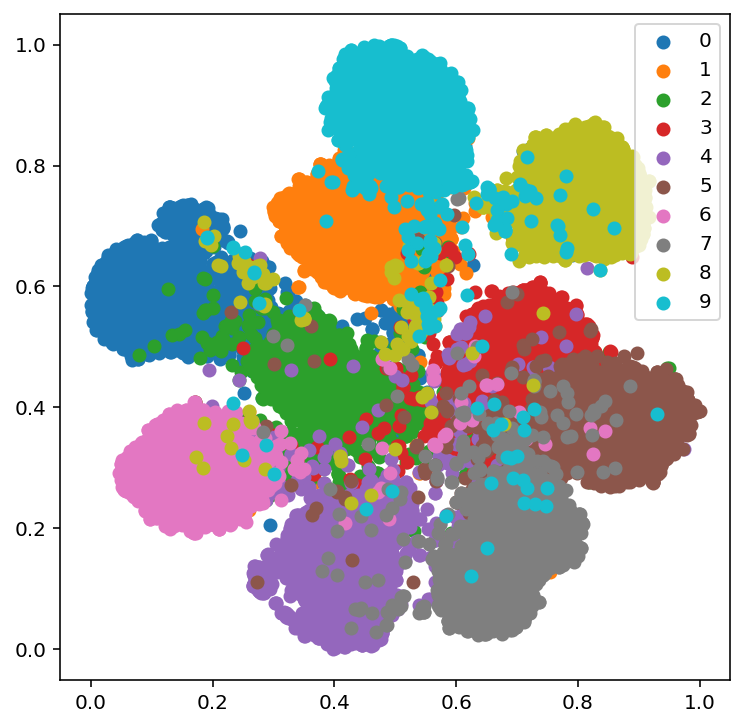

In [ ]:
from sklearn.manifold import TSNE


tsne = TSNE()
images_cpu = [im.cpu().numpy().flatten() for im in images_db]
labels_cpu = [l.cpu().numpy().argmax() for l in labels_db]
X_embedded = tsne.fit_transform(np.array(images_cpu), np.array(labels_cpu))

plot_db(X_embedded, labels_cpu)